In [469]:
%reset -f
import sys
print("Python version")
print(sys.version)

Python version
3.7.9 (tags/v3.7.9:13c94747c7, Aug 17 2020, 18:58:18) [MSC v.1900 64 bit (AMD64)]


In [470]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)

In [471]:
#Coingecko api
from pycoingecko import CoinGeckoAPI
cg = CoinGeckoAPI()

In [472]:
import time
import datetime

def edit_prices_dict(d): 
    df=pd.DataFrame(d)
    #Saving dates
    dates=df['prices'].map(lambda x: x[0])  
    #Filtering the values without dates
    df=df.applymap(lambda x: x[1])
    df['dates']=dates 
    df["dates"] = pd.to_datetime(df['dates'], unit='ms')
    df.index = df["dates"]
    df=df[['prices','total_volumes']]
    return df

In [473]:
#dd/mm/yyyy
from_date="01/03/2018"
to_date="25/11/2021"
from_unix = time.mktime(datetime.datetime.strptime(from_date, "%d/%m/%Y").timetuple())
to_unix = time.mktime(datetime.datetime.strptime(to_date, "%d/%m/%Y").timetuple())

token = "bitcoin"; vs_currency = "usd"

response=cg.get_coin_market_chart_range_by_id(id = token, vs_currency = vs_currency, from_timestamp = from_unix, to_timestamp = to_unix)

In [474]:
df = edit_prices_dict(response)
print(df.shape)
df.tail()

(1365, 2)


,prices,total_volumes
dates,,
2021-11-20,58459.255517,3.785126e+10
2021-11-21,60082.911668,2.967655e+10
2021-11-22,59139.779280,2.574343e+10
2021-11-23,56386.856853,3.400147e+10
2021-11-24,57748.793174,3.642119e+10


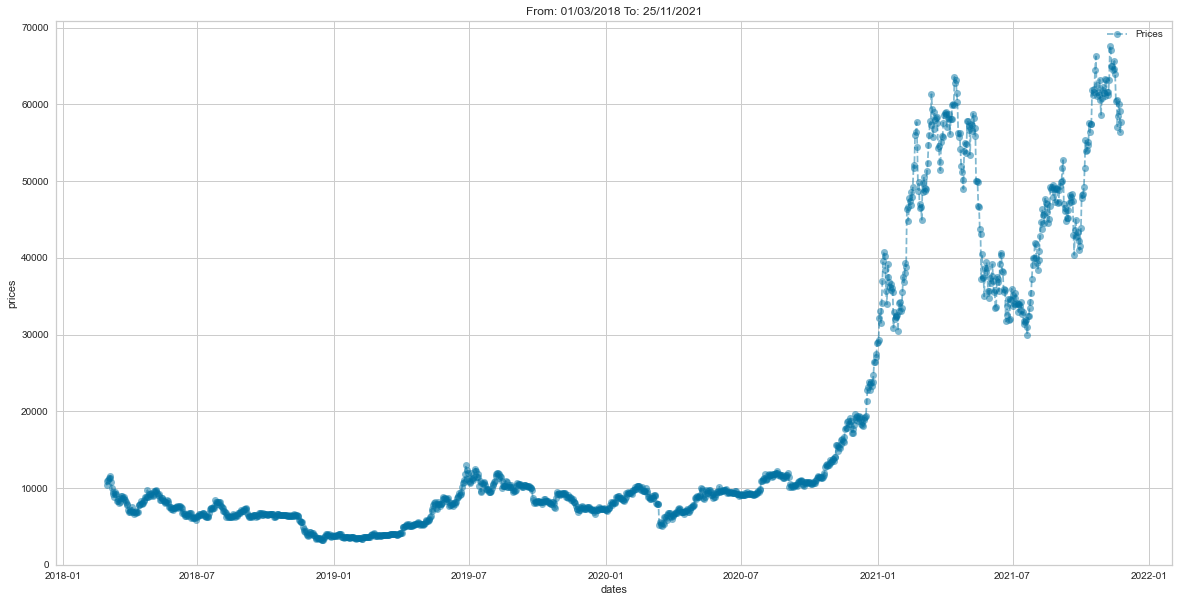

In [475]:
fig=plt.figure(figsize=(20, 10))
plt.plot(df['prices'], '--o', label = 'Prices', alpha = 0.5)
plt.title('From: ' + from_date + ' To: ' + to_date) 
plt.xlabel('dates')
plt.ylabel('prices')
plt.legend()
plt.grid(True)

In [476]:
# Esto hay que hacerlo pues es con la info de hoy predecir mañana
lag_days = 1
df["y"] = df["prices"].shift(-1 * lag_days)
df.tail(5)

,prices,total_volumes,y
dates,,,
2021-11-20,58459.255517,3.785126e+10,60082.911668
2021-11-21,60082.911668,2.967655e+10,59139.779280
2021-11-22,59139.779280,2.574343e+10,56386.856853
2021-11-23,56386.856853,3.400147e+10,57748.793174
2021-11-24,57748.793174,3.642119e+10,NaN


#### Se calculan indicadores para ese día

In [477]:
#https://towardsdatascience.com/building-a-comprehensive-set-of-technical-indicators-in-python-for-quantitative-trading-8d98751b5fb
# MovingAverage
#values_ma = [5,15,30]
#
#for i in values_ma:
#    df["ma_close_" + str(i)] = df["close"].rolling(window=i).mean()
#    df["ma_volume_" + str(i)] = df["volume"].rolling(window=i).mean()

# ExponentialMovingWindow
values_ema = [5,15,30]

for i in values_ema:
    df["ema_" + str(i)] = df["prices"].ewm(span = i, adjust = False).mean()
    
# RSI https://stackoverflow.com/questions/20526414/relative-strength-index-in-python-pandas
values_rsi = [7,14,21]
close = df['prices']

# Get the difference in price from previous step
delta = close.diff()

# Make the positive gains (up) and negative gains (down) Series
up, down = delta.copy(), delta.copy()
up[up < 0] = 0
down[down > 0] = 0

for i in values_rsi:
    # Calculate the EWMA
    #roll_up1 = up.ewm(span=i).mean()
    #roll_down1 = down.abs().ewm(span=i).mean()

    ## Calculate the RSI based on EWMA
    #RS1 = roll_up1 / roll_down1
    #RSI1 = 100.0 - (100.0 / (1.0 + RS1))

    # Calculate the SMA
    roll_up2 = up.rolling(i).mean()
    roll_down2 = down.abs().rolling(i).mean()

    # Calculate the RSI based on SMA
    RS2 = roll_up2 / roll_down2
    RSI2 = 100.0 - (100.0 / (1.0 + RS2))
    
    #df["rsi_ewma_" + str(i)] = RSI1.values
    df["rsi_sma_" + str(i)]  = RSI2.values
    
# BollingerBand
values_bollinger = [5,10,20]
for i in values_bollinger:
    df['bollinger_upper_' + str(i)] = df['prices'].rolling(window=i).mean() + (df['prices'].rolling(window=i).std()  * 2)
    df['bollinger_lower_' + str(i)] = df['prices'].rolling(window=i).mean() - (df['prices'].rolling(window=i).std()  * 2)

# Rate of change
values_rc = [5,15,30]
for i in values_rc:
    df["rc_" + str(i)] = df["prices"].pct_change(periods = i)
    
# Stochastic Oscillators
#values_so = [5,15,30]
#for i in values_so:
#    lowest = df["low"].rolling(window = i).min()
#    high = df["high"].rolling(window = i).max()
#    df["so_" + str(i)] = ((df['close'] -lowest)/(high - lowest))*100
#    df["so_%D" + str(i)] = df["so_" + str(i)].rolling(window = i).mean()

In [478]:
# Get feature from dates
#df['month'] = df.index.month.astype(str)
#df['day'] = df.index.day
#df['weekday'] = df.index.dayofweek.astype(str)
#df['dayofyear'] = df.index.dayofyear

In [479]:
df.sample()

,prices,total_volumes,y,ema_5,ema_15,ema_30,rsi_sma_7,rsi_sma_14,rsi_sma_21,bollinger_upper_5,bollinger_lower_5,bollinger_upper_10,bollinger_lower_10,bollinger_upper_20,bollinger_lower_20,rc_5,rc_15,rc_30
dates,,,,,,,,,,,,,,,,,,
2020-05-31,9662.705873,3.023149e+10,9466.961781,9405.988496,9259.501319,9012.270584,64.511951,54.969238,50.856682,9987.131497,8672.516946,9776.136979,8549.213471,10009.510589,8535.051129,0.08769,0.037963,0.122183


In [480]:
df["y"] = 100*( (df["y"] - df["prices"])/df["prices"])   
df.tail(4)

,prices,total_volumes,y,ema_5,ema_15,ema_30,rsi_sma_7,rsi_sma_14,rsi_sma_21,bollinger_upper_5,bollinger_lower_5,bollinger_upper_10,bollinger_lower_10,bollinger_upper_20,bollinger_lower_20,rc_5,rc_15,rc_30
dates,,,,,,,,,,,,,,,,,,
2021-11-21,60082.911668,2.967655e+10,-1.569718,59945.854855,61663.518176,61215.166452,32.470137,46.480606,46.830976,62428.520747,56204.162415,68164.288708,55888.221212,68312.642859,57212.326578,-0.060233,-0.019013,-0.039305
2021-11-22,59139.779280,2.574343e+10,-4.654942,59677.162996,61348.050814,61081.270505,24.984948,40.826921,45.873479,61899.286405,56209.883463,67431.660020,55447.676724,68404.389504,56922.374741,-0.021651,-0.040894,-0.030960
2021-11-23,56386.856853,3.400147e+10,2.415344,58580.394282,60727.901569,60778.405108,23.139259,22.154860,42.278309,61253.132433,55169.317830,66990.828351,54279.470173,68698.893162,55941.835872,-0.069580,-0.107142,-0.084215
2021-11-24,57748.793174,3.642119e+10,NaN,58303.193913,60355.513019,60582.946274,38.680219,27.686349,40.804333,61165.864340,55561.174256,65840.885540,54047.104549,68732.741026,55369.773090,0.013362,-0.145943,-0.055978


In [481]:
cota_max = 4
cota_min = -4

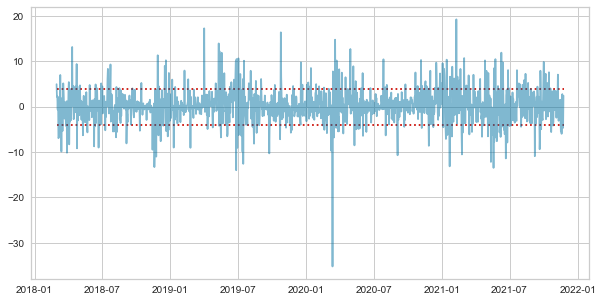

In [482]:
fig=plt.figure(figsize=(10, 5))
plt.plot(df['y'], 'b', label = 'Delta', alpha = 0.5)
plt.hlines(cota_max, df.index.min(), df.index.max(), color='r', ls=':')
plt.hlines(cota_min, df.index.min(), df.index.max(), color='r', ls=':')
plt.grid(True)

In [483]:
def conditions(x):
    if x > cota_max:
        return "Vender"
    elif x < cota_min:
        return "Comprar"
    else:
        return "Mantener"

func = np.vectorize(conditions)
df["y"] = func(df["y"])

In [484]:
df["y"].value_counts()

Mantener    1084
Vender       152
Comprar      129
Name: y, dtype: int64

In [485]:
minus = 15 # Es el lag del pasado cuanto pillamos

In [486]:
df.sample()

,prices,total_volumes,y,ema_5,ema_15,ema_30,rsi_sma_7,rsi_sma_14,rsi_sma_21,bollinger_upper_5,bollinger_lower_5,bollinger_upper_10,bollinger_lower_10,bollinger_upper_20,bollinger_lower_20,rc_5,rc_15,rc_30
dates,,,,,,,,,,,,,,,,,,
2019-04-23,5380.93579,1.719940e+10,Mantener,5308.696791,5155.050658,4888.728181,100.0,55.361449,76.866049,5395.563465,5226.401044,5443.434831,5006.495069,5431.111922,4890.542049,0.031037,0.039397,0.342232


In [487]:
all_columns = list(df.columns)
keep_columns = [item for item in all_columns if item not in "y"]
print(keep_columns)

['prices', 'total_volumes', 'ema_5', 'ema_15', 'ema_30', 'rsi_sma_7', 'rsi_sma_14', 'rsi_sma_21', 'bollinger_upper_5', 'bollinger_lower_5', 'bollinger_upper_10', 'bollinger_lower_10', 'bollinger_upper_20', 'bollinger_lower_20', 'rc_5', 'rc_15', 'rc_30']


In [488]:
df.sample()

,prices,total_volumes,y,ema_5,ema_15,ema_30,rsi_sma_7,rsi_sma_14,rsi_sma_21,bollinger_upper_5,bollinger_lower_5,bollinger_upper_10,bollinger_lower_10,bollinger_upper_20,bollinger_lower_20,rc_5,rc_15,rc_30
dates,,,,,,,,,,,,,,,,,,
2020-03-09,8041.365538,3.913221e+10,Mantener,8639.393882,8929.406524,9102.587038,36.576227,21.725481,30.559593,9644.007437,7906.764512,9353.71838,8121.81109,10223.986231,8037.565079,-0.081692,-0.16744,-0.179406


In [489]:
list_shift = list(range(1, minus))

for i in list_shift:
    for j in keep_columns:
        df[str(j) + "minus" + str(i)] = df[str(j)].shift(i)

In [490]:
print("Shape: " + str(df.shape))
df.dropna(inplace = True)
print("Shape: " + str(df.shape))

Shape: (1365, 256)
Shape: (1321, 256)


In [491]:
df.tail()

,prices,total_volumes,y,ema_5,ema_15,ema_30,rsi_sma_7,rsi_sma_14,rsi_sma_21,bollinger_upper_5,bollinger_lower_5,bollinger_upper_10,bollinger_lower_10,bollinger_upper_20,bollinger_lower_20,rc_5,rc_15,rc_30,pricesminus1,total_volumesminus1,ema_5minus1,ema_15minus1,ema_30minus1,rsi_sma_7minus1,rsi_sma_14minus1,rsi_sma_21minus1,bollinger_upper_5minus1,bollinger_lower_5minus1,bollinger_upper_10minus1,bollinger_lower_10minus1,bollinger_upper_20minus1,bollinger_lower_20minus1,rc_5minus1,rc_15minus1,rc_30minus1,pricesminus2,total_volumesminus2,ema_5minus2,ema_15minus2,ema_30minus2,rsi_sma_7minus2,rsi_sma_14minus2,rsi_sma_21minus2,bollinger_upper_5minus2,bollinger_lower_5minus2,bollinger_upper_10minus2,bollinger_lower_10minus2,bollinger_upper_20minus2,bollinger_lower_20minus2,rc_5minus2,rc_15minus2,rc_30minus2,pricesminus3,total_volumesminus3,ema_5minus3,ema_15minus3,ema_30minus3,rsi_sma_7minus3,rsi_sma_14minus3,rsi_sma_21minus3,bollinger_upper_5minus3,bollinger_lower_5minus3,bollinger_upper_10minus3,bollinger_lower_10minus3,bollinger_upper_20minus3,bollinger_lower_20minus3,rc_5minus3,rc_15minus3,rc_30minus3,pricesminus4,total_volumesminus4,ema_5minus4,ema_15minus4,ema_30minus4,rsi_sma_7minus4,rsi_sma_14minus4,rsi_sma_21minus4,bollinger_upper_5minus4,bollinger_lower_5minus4,bollinger_upper_10minus4,bollinger_lower_10minus4,bollinger_upper_20minus4,bollinger_lower_20minus4,rc_5minus4,rc_15minus4,rc_30minus4,pricesminus5,total_volumesminus5,ema_5minus5,ema_15minus5,ema_30minus5,rsi_sma_7minus5,rsi_sma_14minus5,rsi_sma_21minus5,bollinger_upper_5minus5,bollinger_lower_5minus5,bollinger_upper_10minus5,bollinger_lower_10minus5,bollinger_upper_20minus5,bollinger_lower_20minus5,rc_5minus5,rc_15minus5,rc_30minus5,pricesminus6,total_volumesminus6,ema_5minus6,ema_15minus6,ema_30minus6,rsi_sma_7minus6,rsi_sma_14minus6,rsi_sma_21minus6,bollinger_upper_5minus6,bollinger_lower_5minus6,bollinger_upper_10minus6,bollinger_lower_10minus6,bollinger_upper_20minus6,bollinger_lower_20minus6,rc_5minus6,rc_15minus6,rc_30minus6,pricesminus7,total_volumesminus7,ema_5minus7,ema_15minus7,ema_30minus7,rsi_sma_7minus7,rsi_sma_14minus7,rsi_sma_21minus7,bollinger_upper_5minus7,bollinger_lower_5minus7,bollinger_upper_10minus7,bollinger_lower_10minus7,bollinger_upper_20minus7,bollinger_lower_20minus7,rc_5minus7,rc_15minus7,rc_30minus7,pricesminus8,total_volumesminus8,ema_5minus8,ema_15minus8,ema_30minus8,rsi_sma_7minus8,rsi_sma_14minus8,rsi_sma_21minus8,bollinger_upper_5minus8,bollinger_lower_5minus8,bollinger_upper_10minus8,bollinger_lower_10minus8,bollinger_upper_20minus8,bollinger_lower_20minus8,rc_5minus8,rc_15minus8,rc_30minus8,pricesminus9,total_volumesminus9,ema_5minus9,ema_15minus9,ema_30minus9,rsi_sma_7minus9,rsi_sma_14minus9,rsi_sma_21minus9,bollinger_upper_5minus9,bollinger_lower_5minus9,bollinger_upper_10minus9,bollinger_lower_10minus9,bollinger_upper_20minus9,bollinger_lower_20minus9,rc_5minus9,rc_15minus9,rc_30minus9,pricesminus10,total_volumesminus10,ema_5minus10,ema_15minus10,ema_30minus10,rsi_sma_7minus10,rsi_sma_14minus10,rsi_sma_21minus10,bollinger_upper_5minus10,bollinger_lower_5minus10,bollinger_upper_10minus10,bollinger_lower_10minus10,bollinger_upper_20minus10,bollinger_lower_20minus10,rc_5minus10,rc_15minus10,rc_30minus10,pricesminus11,total_volumesminus11,ema_5minus11,ema_15minus11,ema_30minus11,rsi_sma_7minus11,rsi_sma_14minus11,rsi_sma_21minus11,bollinger_upper_5minus11,bollinger_lower_5minus11,bollinger_upper_10minus11,bollinger_lower_10minus11,bollinger_upper_20minus11,bollinger_lower_20minus11,rc_5minus11,rc_15minus11,rc_30minus11,pricesminus12,total_volumesminus12,ema_5minus12,ema_15minus12,ema_30minus12,rsi_sma_7minus12,rsi_sma_14minus12,rsi_sma_21minus12,bollinger_upper_5minus12,bollinger_lower_5minus12,bollinger_upper_10minus12,bollinger_lower_10minus12,bollinger_upper_20minus12,bollinger_lower_20minus12,rc_5minus12,rc_15minus12,rc_30minus12,pricesminus13,total_volumesminus13,ema_5minus13,ema_15minus13,ema_30minus13,rsi_sma_7minus13,rsi

In [492]:
df.dtypes.value_counts()

float64    255
object       1
dtype: int64

In [493]:
df.shape

(1321, 256)

In [494]:
cutoff = 1000

train = df[0:cutoff]
print(train.shape)

test = df[cutoff:df.shape[0]]
print(test.shape)
test.tail(1)

(1000, 256)
(321, 256)


,prices,total_volumes,y,ema_5,ema_15,ema_30,rsi_sma_7,rsi_sma_14,rsi_sma_21,bollinger_upper_5,bollinger_lower_5,bollinger_upper_10,bollinger_lower_10,bollinger_upper_20,bollinger_lower_20,rc_5,rc_15,rc_30,pricesminus1,total_volumesminus1,ema_5minus1,ema_15minus1,ema_30minus1,rsi_sma_7minus1,rsi_sma_14minus1,rsi_sma_21minus1,bollinger_upper_5minus1,bollinger_lower_5minus1,bollinger_upper_10minus1,bollinger_lower_10minus1,bollinger_upper_20minus1,bollinger_lower_20minus1,rc_5minus1,rc_15minus1,rc_30minus1,pricesminus2,total_volumesminus2,ema_5minus2,ema_15minus2,ema_30minus2,rsi_sma_7minus2,rsi_sma_14minus2,rsi_sma_21minus2,bollinger_upper_5minus2,bollinger_lower_5minus2,bollinger_upper_10minus2,bollinger_lower_10minus2,bollinger_upper_20minus2,bollinger_lower_20minus2,rc_5minus2,rc_15minus2,rc_30minus2,pricesminus3,total_volumesminus3,ema_5minus3,ema_15minus3,ema_30minus3,rsi_sma_7minus3,rsi_sma_14minus3,rsi_sma_21minus3,bollinger_upper_5minus3,bollinger_lower_5minus3,bollinger_upper_10minus3,bollinger_lower_10minus3,bollinger_upper_20minus3,bollinger_lower_20minus3,rc_5minus3,rc_15minus3,rc_30minus3,pricesminus4,total_volumesminus4,ema_5minus4,ema_15minus4,ema_30minus4,rsi_sma_7minus4,rsi_sma_14minus4,rsi_sma_21minus4,bollinger_upper_5minus4,bollinger_lower_5minus4,bollinger_upper_10minus4,bollinger_lower_10minus4,bollinger_upper_20minus4,bollinger_lower_20minus4,rc_5minus4,rc_15minus4,rc_30minus4,pricesminus5,total_volumesminus5,ema_5minus5,ema_15minus5,ema_30minus5,rsi_sma_7minus5,rsi_sma_14minus5,rsi_sma_21minus5,bollinger_upper_5minus5,bollinger_lower_5minus5,bollinger_upper_10minus5,bollinger_lower_10minus5,bollinger_upper_20minus5,bollinger_lower_20minus5,rc_5minus5,rc_15minus5,rc_30minus5,pricesminus6,total_volumesminus6,ema_5minus6,ema_15minus6,ema_30minus6,rsi_sma_7minus6,rsi_sma_14minus6,rsi_sma_21minus6,bollinger_upper_5minus6,bollinger_lower_5minus6,bollinger_upper_10minus6,bollinger_lower_10minus6,bollinger_upper_20minus6,bollinger_lower_20minus6,rc_5minus6,rc_15minus6,rc_30minus6,pricesminus7,total_volumesminus7,ema_5minus7,ema_15minus7,ema_30minus7,rsi_sma_7minus7,rsi_sma_14minus7,rsi_sma_21minus7,bollinger_upper_5minus7,bollinger_lower_5minus7,bollinger_upper_10minus7,bollinger_lower_10minus7,bollinger_upper_20minus7,bollinger_lower_20minus7,rc_5minus7,rc_15minus7,rc_30minus7,pricesminus8,total_volumesminus8,ema_5minus8,ema_15minus8,ema_30minus8,rsi_sma_7minus8,rsi_sma_14minus8,rsi_sma_21minus8,bollinger_upper_5minus8,bollinger_lower_5minus8,bollinger_upper_10minus8,bollinger_lower_10minus8,bollinger_upper_20minus8,bollinger_lower_20minus8,rc_5minus8,rc_15minus8,rc_30minus8,pricesminus9,total_volumesminus9,ema_5minus9,ema_15minus9,ema_30minus9,rsi_sma_7minus9,rsi_sma_14minus9,rsi_sma_21minus9,bollinger_upper_5minus9,bollinger_lower_5minus9,bollinger_upper_10minus9,bollinger_lower_10minus9,bollinger_upper_20minus9,bollinger_lower_20minus9,rc_5minus9,rc_15minus9,rc_30minus9,pricesminus10,total_volumesminus10,ema_5minus10,ema_15minus10,ema_30minus10,rsi_sma_7minus10,rsi_sma_14minus10,rsi_sma_21minus10,bollinger_upper_5minus10,bollinger_lower_5minus10,bollinger_upper_10minus10,bollinger_lower_10minus10,bollinger_upper_20minus10,bollinger_lower_20minus10,rc_5minus10,rc_15minus10,rc_30minus10,pricesminus11,total_volumesminus11,ema_5minus11,ema_15minus11,ema_30minus11,rsi_sma_7minus11,rsi_sma_14minus11,rsi_sma_21minus11,bollinger_upper_5minus11,bollinger_lower_5minus11,bollinger_upper_10minus11,bollinger_lower_10minus11,bollinger_upper_20minus11,bollinger_lower_20minus11,rc_5minus11,rc_15minus11,rc_30minus11,pricesminus12,total_volumesminus12,ema_5minus12,ema_15minus12,ema_30minus12,rsi_sma_7minus12,rsi_sma_14minus12,rsi_sma_21minus12,bollinger_upper_5minus12,bollinger_lower_5minus12,bollinger_upper_10minus12,bollinger_lower_10minus12,bollinger_upper_20minus12,bollinger_lower_20minus12,rc_5minus12,rc_15minus12,rc_30minus12,pricesminus13,total_volumesminus13,ema_5minus13,ema_15minus13,ema_30minus13,rsi_sma_7minus13,rsi

In [495]:
# Importing module and initializing setup
from pycaret.classification import *

setup(data = train,
      target = 'y', feature_interaction=False,
      normalize=True, normalize_method="zscore",
      silent = True, verbose=False);

In [497]:
best = compare_models(sort = 'AUC', exclude = ["ridge"], verbose = True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.6222,0.6558,0.4354,0.7523,0.6723,0.1363,0.1495,0.0050
rf,Random Forest Classifier,0.8141,0.6197,0.3468,0.7023,0.7489,0.0440,0.0586,0.1720
lightgbm,Light Gradient Boosting Machine,0.8169,0.6086,0.3480,0.7096,0.7519,0.0542,0.0789,0.7460
gbc,Gradient Boosting Classifier,0.7955,0.6065,0.3435,0.7057,0.7439,0.0473,0.0547,0.7380
catboost,CatBoost Classifier,0.8155,0.6035,0.3474,0.7082,0.7513,0.0591,0.0974,30.6300
et,Extra Trees Classifier,0.8155,0.5998,0.3577,0.7126,0.7541,0.0656,0.0876,0.1160
lda,Linear Discriminant Analysis,0.7568,0.5607,0.3307,0.7091,0.7262,0.0238,0.0304,0.0100
dt,Decision Tree Classifier,0.6981,0.5546,0.3638,0.7160,0.7053,0.0733,0.0747,0.0250
knn,K Neighbors Classifier,0.8083,0.5333,0.3331,0.6887,0.7412,0.0114,0.0232,0.0300
lr,Logistic Regression,0.7983,0.5257,0.3307,0.6968,0.7391,0.0191,0.0346,0.0370


In [498]:
tuned_model = tune_model(best, optimize= "AUC", n_iter = 10, verbose = True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6000,0.4895,0.4470,0.7312,0.6512,0.0794,0.0884
1,0.6000,0.6473,0.4279,0.7736,0.6629,0.1419,0.1639
2,0.6714,0.7266,0.4567,0.7883,0.7182,0.2081,0.2248
3,0.6857,0.7383,0.5043,0.8087,0.7302,0.2582,0.2847
4,0.5571,0.6539,0.2660,0.7394,0.6330,0.0325,0.0368
5,0.7143,0.7120,0.5767,0.7932,0.7440,0.2742,0.2901
6,0.6000,0.6057,0.3423,0.6822,0.6362,0.0031,0.0032
7,0.6429,0.6582,0.5455,0.7355,0.6743,0.1765,0.1904
8,0.6286,0.6964,0.4323,0.7402,0.6736,0.1423,0.1528
9,0.5652,0.6333,0.3724,0.7441,0.6331,0.0808,0.0927


In [500]:
# finalize a model
final_model = finalize_model(tuned_model)

In [501]:
predictions = predict_model(final_model, data = test)

In [502]:
predictions.sample()

,prices,total_volumes,y,ema_5,ema_15,ema_30,rsi_sma_7,rsi_sma_14,rsi_sma_21,bollinger_upper_5,...,bollinger_lower_5minus14,bollinger_upper_10minus14,bollinger_lower_10minus14,bollinger_upper_20minus14,bollinger_lower_20minus14,rc_5minus14,rc_15minus14,rc_30minus14,Label,Score
dates,,,,,,,,,,,,,,,,,,,,,
2021-09-20,47371.039332,2.616317e+10,Comprar,47511.579259,47437.033326,47033.594164,58.406511,38.14031,46.876272,48726.140197,...,47793.998516,51742.349885,46496.088181,51818.724959,45037.09682,0.092125,0.056454,0.207795,Vender,1.0


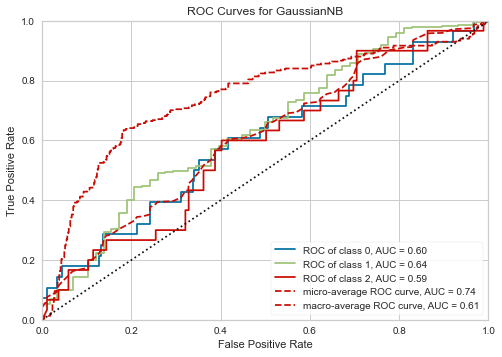

In [503]:
plot_model(final_model)

In [504]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true = predictions["y"], y_pred = predictions["Label"])

array([[  0,   0,  40],
       [  0,   0, 235],
       [  0,   0,  46]], dtype=int64)

### Telegram

In [167]:
import telepot

bot_token = '1653124784:AAFpL0qlC_ybadcbFX6jKagauRFpiFpSf1E'
chatID = '-625272860'

bot = telepot.Bot(bot_token)

In [168]:
#ot.sendMessage(bot_chatID, "HALA")
bot.sendPhoto(chatID, photo=open('imagen.png', 'rb'))

{'message_id': 107,
 'from': {'id': 1653124784,
  'is_bot': True,
  'first_name': 'JARVIS',
  'username': 'JARVIS_Walkn_bot'},
 'chat': {'id': -625272860,
  'title': 'Trading',
  'type': 'group',
  'all_members_are_administrators': True},
 'date': 1637896017,
 'photo': [{'file_id': 'AgACAgQAAxkDAANrYaBPUV6axk1vyzCmCRrt8HVu468AAui3MRsUYwABURgzD2eGDIwBAQADAgADcwADIgQ',
   'file_unique_id': 'AQAD6LcxGxRjAAFReA',
   'file_size': 758,
   'width': 90,
   'height': 45},
  {'file_id': 'AgACAgQAAxkDAANrYaBPUV6axk1vyzCmCRrt8HVu468AAui3MRsUYwABURgzD2eGDIwBAQADAgADbQADIgQ',
   'file_unique_id': 'AQAD6LcxGxRjAAFRcg',
   'file_size': 9967,
   'width': 320,
   'height': 160},
  {'file_id': 'AgACAgQAAxkDAANrYaBPUV6axk1vyzCmCRrt8HVu468AAui3MRsUYwABURgzD2eGDIwBAQADAgADeAADIgQ',
   'file_unique_id': 'AQAD6LcxGxRjAAFRfQ',
   'file_size': 41074,
   'width': 800,
   'height': 400},
  {'file_id': 'AgACAgQAAxkDAANrYaBPUV6axk1vyzCmCRrt8HVu468AAui3MRsUYwABURgzD2eGDIwBAQADAgADeQADIgQ',
   'file_unique_id': 'AQAD